# Airfoil optimization

In [1]:
from IPython.display import SVG, display

import torch
import torch.nn as nn
import torch.optim as optim
from torch import distributions
from torch.distributions import Normal

#stuff for neurofoil - pip install neuralfoil
from aerosandbox.geometry.airfoil.airfoil_families import get_kulfan_parameters, get_kulfan_coordinates
import aerosandbox as asb
import aerosandbox.numpy as np
import matplotlib.pyplot as plt
import aerosandbox.tools.pretty_plots as p

import matplotlib.pyplot as plt
import aerosandbox.tools.pretty_plots as p

import sys
import os
import contextlib
from collections import deque
import copy

import warnings
import pennylane as qml

## Procedure 

Sources:
* http://servidor.demec.ufpr.br/CFD/bibliografia/aerodinamica/kulfan_2007.pdf
* https://www.tandfonline.com/doi/epdf/10.1080/19942060.2024.2445144
* https://github.com/peterdsharpe/NeuralFoil


Here the PINN is allready trained an provides the prediction. Therefore, the idea is, we shift the quantum opt. part to approximate a policy. 

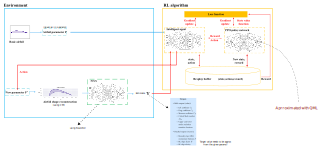

In [3]:
display(SVG(filename="optimprocedure.svg"))

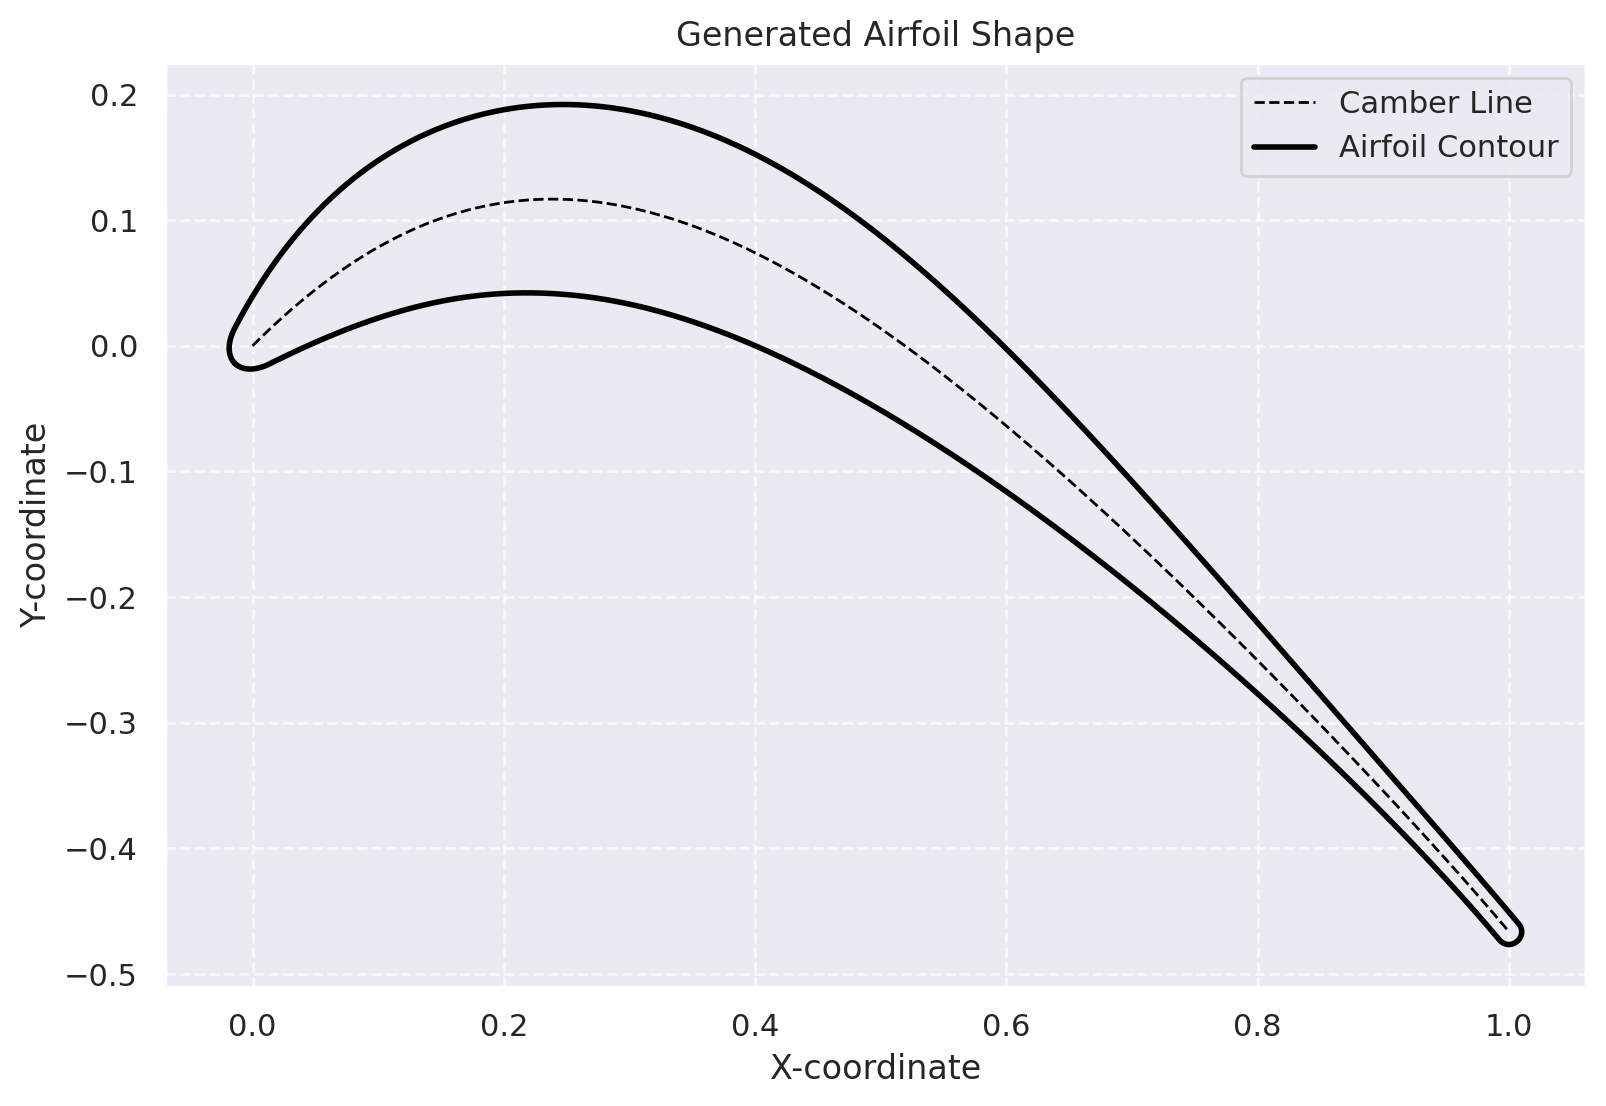

In [4]:
sys.path.append(os.path.abspath("../blade_design_tools"))
import create_airfoil as ca
airfoil_top_points, airfoil_bottom_points, camber_curve_points = ca.generate_shape(config_filepath="../blade_design_tools/airfoil_config.yaml")

In [5]:
def get_neuralfoil_coordinates(airfoil_top_points, airfoil_bottom_points):
    """
        stacking is up for neurofoil
    """
    # Upper surface: reverse to go from TE to LE
    upper_te_to_le = np.flip(airfoil_top_points, axis=0)

    # Lower surface: LE to TE as is
    lower_le_to_te = airfoil_bottom_points

    # Check if LE points match (for sharp LE); avoid duplicating if so
    if np.allclose(upper_te_to_le[-1], lower_le_to_te[0]):
        coordinates = np.vstack((upper_te_to_le, lower_le_to_te[1:]))
    else:
        coordinates = np.vstack((upper_te_to_le, lower_le_to_te))
    return coordinates


# 7. Export for NeuralFoil
coordinates = get_neuralfoil_coordinates(airfoil_top_points, airfoil_bottom_points)
kulfan_params = get_kulfan_parameters(coordinates)
print("Kulfan parameters:", kulfan_params)

Kulfan parameters: {'lower_weights': array([-0.39463068,  0.5726026 ,  0.17745471,  0.6048875 ,  0.28333585,
        0.40413929,  0.45693178,  0.35682846]), 'upper_weights': array([0.67150686, 0.39899314, 1.0069387 , 0.45522572, 0.61792343,
       0.60628315, 0.35938593, 0.60352649]), 'TE_thickness': 0.01324605086387115, 'leading_edge_weight': 1.103184527384567}


In [6]:
CL_multipoint_targets = np.array([0.8, 1.0, 1.2, 1.4, 1.5, 1.6])
CL_multipoint_weights = np.array([5, 6, 7, 8, 9, 10])

Re = 500e3 * (CL_multipoint_targets / 1.25) ** -0.5
mach = 0.7

In [7]:
Re

array([625000.        , 559016.99437495, 510310.36307983, 472455.59126153,
       456435.46458764, 441941.73824159])

In [8]:
def opt_state(initial_guess_airfoil):
    opti_ = asb.Opti()
    optimized_airfoil_ = asb.KulfanAirfoil(
        name="Optimized",
        lower_weights=opti_.variable(
            init_guess=initial_guess_airfoil.lower_weights,
            lower_bound=-0.5,
            upper_bound=0.25,
        ),
        upper_weights=opti_.variable(
            init_guess=initial_guess_airfoil.upper_weights,
            lower_bound=-0.25,
            upper_bound=0.5,
        ),
        leading_edge_weight=opti_.variable(
            init_guess=initial_guess_airfoil.leading_edge_weight,
            lower_bound=-1,
            upper_bound=1,
        ),
        TE_thickness=kulfan_params["TE_thickness"],
    )

    alpha_ = opti_.variable(
        init_guess=45
    )


    aero_ = optimized_airfoil_.get_aero_from_neuralfoil(
        alpha=alpha_,
        Re=Re,
        mach=mach,
    )
    return aero_, optimized_airfoil_, alpha_, opti_

# Test optimization frame work
### TODO's: 
- Implement real costfunction
- Shape constraints
- Implement the PPO, here we compare standard PPO vs. Quantum PPO

In [9]:
def get_optim(opti_, aero_, target_, initial_guess, alpha_):
    opti_.subject_to([
        aero_["analysis_confidence"] > 0.90,
        aero_["CL"] == CL_multipoint_targets,
        np.diff(alpha_) > 0,
        aero_["CM"] >= -0.133,
        target_.local_thickness(x_over_c=0.33) >= 0.128,
        target_.local_thickness(x_over_c=0.90) >= 0.014,
        target_.TE_angle() >= 6.03, 
        target_.lower_weights[0] < -0.05,
        target_.upper_weights[0] > 0.05,
        target_.local_thickness() > 0
    ])
    
    get_wiggliness = lambda af: sum([
        np.sum(np.diff(np.diff(array)) ** 2)
        for array in [af.lower_weights, af.upper_weights]
    ])
    
    opti_.subject_to(
        get_wiggliness(target_) < 2 * get_wiggliness(initial_guess)
    )
    
    
    # Formulate an optimization goal based
    opti_.maximize(np.mean(aero_["CL"] / aero_["CD"]))
    
    sol = opti_.solve(
        max_iter = 10,
        behavior_on_failure="return_last",
        options={
           # "ipopt.mu_strategy": 'monotone',
           # "ipopt.start_with_resto": 'yes'
        }
    )
    return sol

#optimized_airfoil_0 = sol(optimized_airfoil)

### Interface for NeuralFoil
This provides the values employed for guiding the optimization, here the method call for `get_aero_from_neuralfoil` yields the following values. Question: how to use this parameter to approximate our loss value sought? 

```python
return {
            "analysis_confidence": nf_aero["analysis_confidence"],
            "CL": CL,
            "CD": CD,
            "CM": CM,
            "Cpmin": Cpmin,
            "Top_Xtr": Top_Xtr,
            "Bot_Xtr": Bot_Xtr,
            "mach_crit": mach_crit,
            "mach_dd": mach_dd,
            "Cpmin_0": Cpmin_0,
            **{f"upper_bl_theta_{i}": nf_aero[f"upper_bl_theta_{i}"] for i in range(N)},
            **{f"upper_bl_H_{i}": nf_aero[f"upper_bl_H_{i}"] for i in range(N)},
            **{
                f"upper_bl_ue/vinf_{i}": nf_aero[f"upper_bl_ue/vinf_{i}"]
                for i in range(N)
            },
            **{f"lower_bl_theta_{i}": nf_aero[f"lower_bl_theta_{i}"] for i in range(N)},
            **{f"lower_bl_H_{i}": nf_aero[f"lower_bl_H_{i}"] for i in range(N)},
            **{
                f"lower_bl_ue/vinf_{i}": nf_aero[f"lower_bl_ue/vinf_{i}"]
                for i in range(N)
            },
        }
```

Hint the returns values such as CL are wrapped into Casadi type. Therefore we need to employ solve to evaluate the AD graph. 

In [10]:
#modified shape_method
def generate_shape(config_filepath="airfoil_config.yaml", config_dict=None, plot_foil=False):
    try:
        config = ca.load_config(config_filepath) if config_dict is None else config_dict
        
        # Handle optional input targets for chord and max thickness
        input_targets = config.get('input_targets', {})
        desired_chord = input_targets.get('desired_chord_length', None)
        desired_max_th = input_targets.get('desired_max_thickness', None)
        
        # Temporarily compute camber to get normalized chord (needed for adjustments)
        temp_camber_control_points, temp_camber_curve_points = ca.compute_curve_points(
            config['camber_line'], "camber", config['output_settings']['num_points_on_curve']
        )
        norm_le = temp_camber_curve_points[0]
        norm_te = temp_camber_curve_points[-1]
        norm_chord = np.linalg.norm(norm_te - norm_le)
        norm_x_span = norm_te[0] - norm_le[0]  # Should be 1.0
        
        # Adjust chord_length_for_export if desired_chord is set (to achieve desired geometric chord)
        if desired_chord is not None:
            config['output_settings']['chord_length_for_export'] = desired_chord * (norm_x_span / norm_chord)  # Equivalent to desired_chord * np.cos(np.deg2rad(np.abs(config['camber_line']['stagger_angle_deg'])))
        
        # 1. Compute Camber Line
        camber_control_points, camber_curve_points = ca.compute_curve_points(
            config['camber_line'], "camber", config['output_settings']['num_points_on_curve']
        )
       
        # 2. Compute Top Thickness Distribution
        top_thickness_control_points, top_thickness_curve_points = ca.compute_curve_points(
            config['top_thickness'], "top_thickness", config['output_settings']['num_points_on_curve']
        )
        # 3. Compute Bottom Thickness Distribution
        bottom_thickness_control_points, bottom_thickness_curve_points = ca.compute_curve_points(
            config['bottom_thickness'], "bottom_thickness", config['output_settings']['num_points_on_curve']
        )
        
        # Temporarily compute current normalized max thickness
        current_norm_thickness_along = top_thickness_curve_points[:, 1] + bottom_thickness_curve_points[:, 1]
        current_norm_max_th = np.max(current_norm_thickness_along)
        
        # Compute scale factor (reflects any chord adjustment)
        scale = config['output_settings']['chord_length_for_export'] / norm_x_span
        
        # Adjust thickness curves if desired_max_th is set
        if desired_max_th is not None:
            desired_norm_max_th = desired_max_th / scale
            th_scale_factor = desired_norm_max_th / current_norm_max_th
            top_thickness_curve_points[:, 1] *= th_scale_factor
            bottom_thickness_curve_points[:, 1] *= th_scale_factor
        
        # 4. Generate Full Airfoil Contour
        airfoil_top_points, airfoil_bottom_points = ca.generate_airfoil_contour(
            camber_curve_points,
            top_thickness_curve_points,
            bottom_thickness_curve_points,
            config['camber_line']['inlet_angle_deg'],
            config['output_settings']['num_points_on_arc']
        )
        # 5. Plot the Airfoil
        if plot_foil:
            ca.plot_airfoil(camber_curve_points, airfoil_top_points, airfoil_bottom_points,
                         config['output_settings']['plot_title'])
    except:
        pass
       
    return airfoil_top_points, airfoil_bottom_points, camber_curve_points

In [11]:
# Starting with to adjustable params:
# NetworkA -> ChordLength + MaxThickness - using black box function to translate this into our parametrization
config = ca.load_config("../blade_design_tools/airfoil_config.yaml")

In [12]:
#config['input_targets'] = {
#    "desired_chord_length" : 1.0,
#    "desired_max_thickness": 0.05
#}

# Actor crtitic training
- For the purpose of a prototype, we start modifying a few control points
```python
camber_line:
  control_points_params:
    P1_k_factor: 0.4
    P2_x: 0.5
    P2_y: 0.05
    P3_k_factor: -0.25
  inlet_angle_deg: 45
  outlet_angle_deg: -50
  stagger_angle_deg: -25

top_thickness:
  control_points_params:
    P1_k_factor: 0.2
    P2_x: 0.1
    P2_y: 0.03
    P3_k_factor: 0
  inlet_angle_deg: 40
  outlet_angle_deg: -0
  le_y_thickness: 0.02 # Y-coordinate of P0 for thickness curve (half-thickness at LE)
  p4_y: 0.01           # Y-coordinate of P4 for thickness curve (half-thickness at TE)

bottom_thickness:
  control_points_params:
    P1_k_factor: 0.2
    P2_x: 0.1
    P2_y: 0.03
    P3_k_factor: 0
  inlet_angle_deg: 40
  outlet_angle_deg: -0
  le_y_thickness: 0.02 # Y-coordinate of P0 for thickness curve (half-thickness at LE)
  p4_y: 0.01           # Y-coordinate of P4 for thickness curve (half-thickness at TE)
  ```

In [13]:
@torch.no_grad()
def external_eval(actions, plot_foil=False):  # actions might be given as numpy
    with open(os.devnull, 'w') as devnull:
        with contextlib.redirect_stdout(devnull):
            actions_ = actions.numpy()[0]
            fail_ret_val = torch.tensor([-1]), actions
            if actions_[0]<actions_[2]:
                return fail_ret_val
            
            print(actions)
            c_p1_lower_bound = 0.15
            c_p3_lower_bound = -0.3
            t_p1_k_lower_bound = 0.15
            t_le_y_thick_lower_bound = 0.01
 
            c_p1_upper_bound = 0.5
            c_p3_upper_bound = -0.1
            t_p1_k_upper_bound  = 0.4
            t_le_y_thick_upper_bound = 0.04
            
            config["camber_line"]["control_points_params"]["P1_k_factor"] = c_p1_lower_bound + actions_[0] * (c_p1_upper_bound - c_p1_lower_bound)
            config["camber_line"]["control_points_params"]["P3_k_factor"] = c_p3_lower_bound + actions_[1] * (c_p3_upper_bound - (c_p3_lower_bound))
            
            # Scale and assign top_thickness parameters
            config["top_thickness"]["control_points_params"]["P1_k_factor"] = t_p1_k_lower_bound + actions_[2] * (t_p1_k_upper_bound - t_p1_k_lower_bound)
            config["top_thickness"]["le_y_thickness"] = t_le_y_thick_lower_bound + actions_[3] * (t_le_y_thick_upper_bound - t_le_y_thick_lower_bound)
           
            # parse actions to generate shape
            airfoil_top_points, airfoil_bottom_points, _ = generate_shape(config_dict=config, plot_foil=plot_foil)
       
            # transform shape -> later we replace this with the fortran solver
            coordinates = get_neuralfoil_coordinates(airfoil_top_points, airfoil_bottom_points)
            kulfan_params = get_kulfan_parameters(coordinates)
            kulfan_airfoil_ = asb.KulfanAirfoil(name="State 1'", **kulfan_params)
           
            # parametrize the optimization states:
            aero_new, optimized_airfoil_new, alpha_new, opti_new = opt_state(kulfan_airfoil_)
            try:
                sol = get_optim(opti_new, aero_new, optimized_airfoil_new, kulfan_airfoil_, alpha_new)
                resolved_values_0 = sol(aero_new)
            except:
               return torch.tensor([0]), actions
            ratio = torch.tensor(resolved_values_0["CL"] / resolved_values_0["CD"])
            # define a cost value
    return torch.mean(ratio), torch.tensor([[np.mean(resolved_values_0["CL"]), np.mean(resolved_values_0["CL"])]], dtype=torch.float32)


# First attempt - simple AC with a vanilla policy opt. 

```python
class Actor(nn.Module):
    def __init__(self, n_numbers, hidden_dim=128):
        super(Actor, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(2, hidden_dim),  # Simple state input (can be modified)
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, n_numbers * 2)  # Mean and log_std for each number
        )
        self.n_numbers = n_numbers
    def forward(self, state):
        params = self.network(state)
        mean, log_std = params[:, :self.n_numbers], params[:, self.n_numbers:]
        std = log_std.exp()
        dist = distributions.Normal(mean, std)
        action = dist.sample()
        log_prob = dist.log_prob(action).sum(dim=-1)
        return action, log_prob

class Critic(nn.Module):
    def __init__(self, n_numbers, hidden_dim=128):
        super(Critic, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(2 + n_numbers, hidden_dim),  # State (dim 2) + action
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)  # Value estimate
        )
    def forward(self, state, action):
        x = torch.cat([state, action], dim=-1)
        return self.network(x)

def train_actor_critic(n_numbers, num_episodes=1000, lr_actor=1e-4, lr_critic=1e-4, gamma=0.90):
    actor = Actor(n_numbers)
    critic = Critic(n_numbers)
    actor_optimizer = optim.Adam(actor.parameters(), lr=lr_actor)
    critic_optimizer = optim.Adam(critic.parameters(), lr=lr_critic)
    plot_foil = False
    state = torch.tensor([[1.0, 1.0]], dtype=torch.float32)
    for episode in range(num_episodes):
        action, log_prob = actor(state)
        reward, state = external_eval(action, plot_foil)
        # Critic estimates value
        value = critic(state, action)
        # Compute advantage
        advantage = reward - value.detach()
        # Critic loss: Mean squared error
        critic_loss = (reward - value).pow(2).mean()
        critic_optimizer.zero_grad()
        critic_loss.backward()
        critic_optimizer.step()
        # Actor loss: Policy gradient
        actor_loss = -(log_prob * advantage).mean()
        actor_optimizer.zero_grad()
        actor_loss.backward()
        actor_optimizer.step()
        if episode % 50 == 0:
            print(f"Episode {episode}, Reward: {reward.item():.4f}, Actor Loss: {actor_loss.item():.4f}, Critic Loss: {critic_loss.item():.4f}")
            plot_foil = True
        else:
            plot_foil = False

if __name__ == "__main__":
    n_numbers = 4
    train_actor_critic(n_numbers)
```

# Refine AC with PPO

In [14]:
# Networks
class Actor(nn.Module):
    def __init__(self, state_dim, n_numbers, hidden_dim=128):
        super(Actor, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, n_numbers * 2)
        )
        self.n_numbers = n_numbers

    def forward(self, state):
        # Ensure batch dimension
        if state.dim() == 1:
            state = state.unsqueeze(0)
        
        output = self.network(state)
        mean = output[:, :self.n_numbers]
        log_std = output[:, self.n_numbers:]
        log_std = torch.clamp(log_std, -20, 2)
        std = log_std.exp()
        return mean, std

    def get_action_and_log_prob(self, state):
        mean, std = self.forward(state)
        
        # Create normal distribution for each action dimension
        dist = distributions.Normal(mean, std)
        action = dist.sample()
        
        # Calculate log probability (sum across action dimensions)
        log_prob = dist.log_prob(action).sum(dim=-1)
        
        return action, log_prob

    def get_log_prob(self, state, action):
        mean, std = self.forward(state)
        
        # Reshape action to match expected dimensions if needed
        if action.dim() != mean.dim():
            action = action.view(mean.shape)
            
        dist = distributions.Normal(mean, std)
        log_prob = dist.log_prob(action).sum(dim=-1)
        return log_prob

    def get_entropy(self, state):
        mean, std = self.forward(state)
        dist = distributions.Normal(mean, std)
        entropy = dist.entropy().sum(dim=-1)
        return entropy

class Critic(nn.Module):
    def __init__(self, state_dim, hidden_dim=128):
        super(Critic, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, state):
        if state.dim() == 1:
            state = state.unsqueeze(0)
        return self.network(state)

class PPOBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.reset()

    def reset(self):
        self.states = []
        self.actions = []
        self.log_probs = []
        self.rewards = []
        self.values = []
        self.dones = []
        self.next_states = []

    def store(self, state, action, log_prob, reward, value, done, next_state):
        self.states.append(state.clone())
        self.actions.append(action.clone())
        self.log_probs.append(log_prob.clone())
        self.rewards.append(reward)
        self.values.append(value.clone())
        self.dones.append(done)
        self.next_states.append(next_state.clone())

    def get(self):
        states = torch.stack(self.states)
        actions = torch.stack(self.actions)
        log_probs = torch.stack(self.log_probs)
        rewards = torch.tensor(self.rewards, dtype=torch.float32)
        values = torch.stack(self.values).squeeze(-1)
        dones = torch.tensor(self.dones, dtype=torch.float32)
        next_states = torch.stack(self.next_states)
        
        return states, actions, log_probs, rewards, values, dones, next_states

    def size(self):
        return len(self.states)

    def clear(self):
        self.reset()



class qCritic(nn.Module):
    def __init__(self, state_dim, hidden_dim=128, n_qubits=None, n_layers=3):
        super(qCritic, self).__init__()
        
        self.n_qubits = n_qubits if n_qubits is not None else state_dim
        
        self.input_layer = nn.Linear(state_dim, hidden_dim)
        
        self.dev = qml.device("default.qubit", wires=self.n_qubits)
        
        @qml.qnode(self.dev, interface="torch")
        def quantum_circuit(inputs, weights):
            qml.AngleEmbedding(inputs, wires=range(self.n_qubits)) # encode via angle embedding
            
            # Variational quantum circuit with n_layers
            for layer in range(n_layers):
                # Add parameterized rotation gates
                for qubit in range(self.n_qubits):
                    qml.RX(weights[layer, qubit, 0], wires=qubit)
                    qml.RY(weights[layer, qubit, 1], wires=qubit)
                    qml.RZ(weights[layer, qubit, 2], wires=qubit)
                # Add entanglement
                for qubit in range(self.n_qubits - 1):
                    qml.CNOT(wires=[qubit, qubit + 1])
            
            # Measure expectation values of Pauli-Z for each qubit
            return [qml.expval(qml.PauliZ(w)) for w in range(self.n_qubits)]
        
        # Initialize quantum weights (n_layers x n_qubits x 3 rotations per qubit)
        weight_shapes = {"weights": (n_layers, self.n_qubits, 3)}
        self.quantum_layer = qml.qnn.TorchLayer(quantum_circuit, weight_shapes)
        
        # Classical output layer to map quantum outputs to a single value
        self.output_layer = nn.Linear(self.n_qubits, 1)
        
        # Activation for classical layers
        self.relu = nn.ReLU()
    
    def forward(self, state):
        if state.dim() == 1:
            state = state.unsqueeze(0)  # Add batch dimension if needed
        
        # Classical input processing
        x = self.relu(self.input_layer(state))
        
        # Quantum layer processing
        x = self.quantum_layer(x)
        
        # Classical output processing
        value = self.output_layer(x)
        
        return value

In [15]:
def compute_gae(rewards, values, next_values, dones, gamma=0.99, lam=0.95): #Generalized Advantage Estimation -> computes adventages values
    advantages = torch.zeros_like(rewards)
    gae = 0
    
    for i in reversed(range(len(rewards))):
        if i == len(rewards) - 1:
            next_value = next_values[-1]
        else:
            next_value = values[i + 1]
            
        delta = rewards[i] + gamma * next_value * (1 - dones[i]) - values[i]
        gae = delta + gamma * lam * (1 - dones[i]) * gae
        advantages[i] = gae
    
    returns = advantages + values
    return advantages, returns

def train_ppo(actor, critic,
              external_eval_func, n_numbers=4, state_dim=2, num_episodes=1000, 
              steps_per_episode=100, lr_actor=3e-4, lr_critic=1e-4, gamma=0.99, 
              lam=0.95, clip_ratio=0.2, ppo_epochs=4, batch_size=64, 
              value_loss_coef=0.5, entropy_coef=0.01):
    
    # Optimizers
    actor_optimizer = optim.Adam(actor.parameters(), lr=lr_actor)
    critic_optimizer = optim.Adam(critic.parameters(), lr=lr_critic)
    
    # Initialize state - you'll need to modify this based on your actual initial state
    state = torch.tensor([0.0, 0.0], dtype=torch.float32).to(device)
    
    episode_rewards = []
    
    for episode in range(num_episodes):
        print(f"\nEpisode {episode + 1}/{num_episodes}")
        
        # Storage for this episode
        buffer = PPOBuffer(steps_per_episode)
        
        for step in range(steps_per_episode):
            with torch.no_grad():
                # Get action and log probability
                action, log_prob = actor.get_action_and_log_prob(state)
                
                # Get value estimate
                value = critic(state)
                
                #print(f"Step {step}: Action shape: {action.shape}, Action: {action}")
                
                # Call your external evaluation function
                try:
                    reward, next_state = external_eval_func(action, plot_foil=False)
                    
                    # Ensure next_state has correct shape for your state representation
                    if next_state.dim() == 2 and next_state.shape[0] == 1:
                        next_state = next_state.squeeze(0)  # Remove batch dimension if present
                    
                    # Ensure next_state matches your state_dim
                    if next_state.shape[0] != state_dim:
                        # You might need to modify this based on how you want to represent state
                        next_state = next_state[:state_dim]  # Truncate or pad as needed
                    
                    next_state = next_state.to(device)
                    
                    # Store transition
                    buffer.store(
                        state=state,
                        action=action, 
                        log_prob=log_prob,
                        reward=reward.item(),
                        value=value,
                        done=0.0,  # Assuming episodes don't terminate early
                        next_state=next_state
                    )
                    state = next_state
                    
                except Exception as e:
                    print(f"Error in external_eval at step {step}: {e}")
                    print(f"Action shape: {action.shape}, Action: {action}")
                    # Skip this step or handle error as needed
                    continue
        
        if buffer.size() == 0:
            continue
            
        # Get all data from buffer
        states, actions, old_log_probs, rewards, values, dones, next_states = buffer.get()
        
        #highest reward: 
        index = np.argmax(rewards)
        print(f"Best reward: {actions[index]} - {rewards[index]}")
        external_eval_func(actions[index], plot_foil=True)

        
        states = states.to(device)
        actions = actions.to(device) 
        old_log_probs = old_log_probs.to(device)
        rewards = rewards.to(device)
        values = values.to(device)
        dones = dones.to(device)
        next_states = next_states.to(device)
        
        # Compute next values for GAE
        with torch.no_grad():
            next_values = critic(next_states).squeeze(-1)
        
        # Compute advantages and returns
        advantages, returns = compute_gae(rewards, values, next_values, dones, gamma, lam)
        advantages = advantages.to(device)
        returns = returns.to(device)
        
        # Normalize advantages
        if advantages.std() > 1e-8:
            advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
        
        # PPO update
        dataset_size = buffer.size()
        
        for ppo_epoch in range(ppo_epochs):
            # Shuffle data
            indices = torch.randperm(dataset_size)
            
            for start_idx in range(0, dataset_size, batch_size):
                end_idx = min(start_idx + batch_size, dataset_size)
                batch_indices = indices[start_idx:end_idx]
                
                # Get batch data
                batch_states = states[batch_indices]
                batch_actions = actions[batch_indices]
                batch_old_log_probs = old_log_probs[batch_indices]
                batch_advantages = advantages[batch_indices]
                batch_returns = returns[batch_indices]
                
                # Forward pass
                new_log_probs = actor.get_log_prob(batch_states, batch_actions)
                new_values = critic(batch_states).squeeze(-1)
                
                # PPO loss
                ratio = torch.exp(new_log_probs - batch_old_log_probs)
                surr1 = ratio * batch_advantages
                surr2 = torch.clamp(ratio, 1 - clip_ratio, 1 + clip_ratio) * batch_advantages
                policy_loss = -torch.min(surr1, surr2).mean()
                
                # Add entropy bonus
                entropy = actor.get_entropy(batch_states).mean()
                policy_loss = policy_loss - entropy_coef * entropy
                
                # Value loss
                value_loss = nn.MSELoss()(new_values, batch_returns)
                
                # Update actor
                actor_optimizer.zero_grad()
                policy_loss.backward()
                nn.utils.clip_grad_norm_(actor.parameters(), 0.5)
                actor_optimizer.step()
                
                # Update critic  
                critic_optimizer.zero_grad()
                value_loss.backward()
                nn.utils.clip_grad_norm_(critic.parameters(), 0.5)
                critic_optimizer.step()
        
        # Log episode results
        episode_reward = rewards.median().item()
        episode_rewards.append(episode_reward)
        if episode>0 and episode%10==0:
            print(f"Episode {episode + 1} - Total Reward: {episode_reward:.4f}")
            print(f"  Mean Reward: {rewards.mean().item():.4f}")
            print(f"  Policy Loss: {policy_loss.item():.4f}")
            print(f"  Value Loss: {value_loss.item():.4f}")
            print(f"  Entropy: {entropy.item():.4f}")
        
        # Print running statistics
        if len(episode_rewards) >= 10:
            recent_mean = np.mean(episode_rewards[-10:])
            print(f"  Recent 10 episodes average: {recent_mean:.4f}")
    
    return actor, critic, episode_rewards

Using device: cpu

Episode 1/10
Best reward: tensor([[ 0.1754,  0.9897, -0.1908,  0.9309]]) - 3.9653046131134033


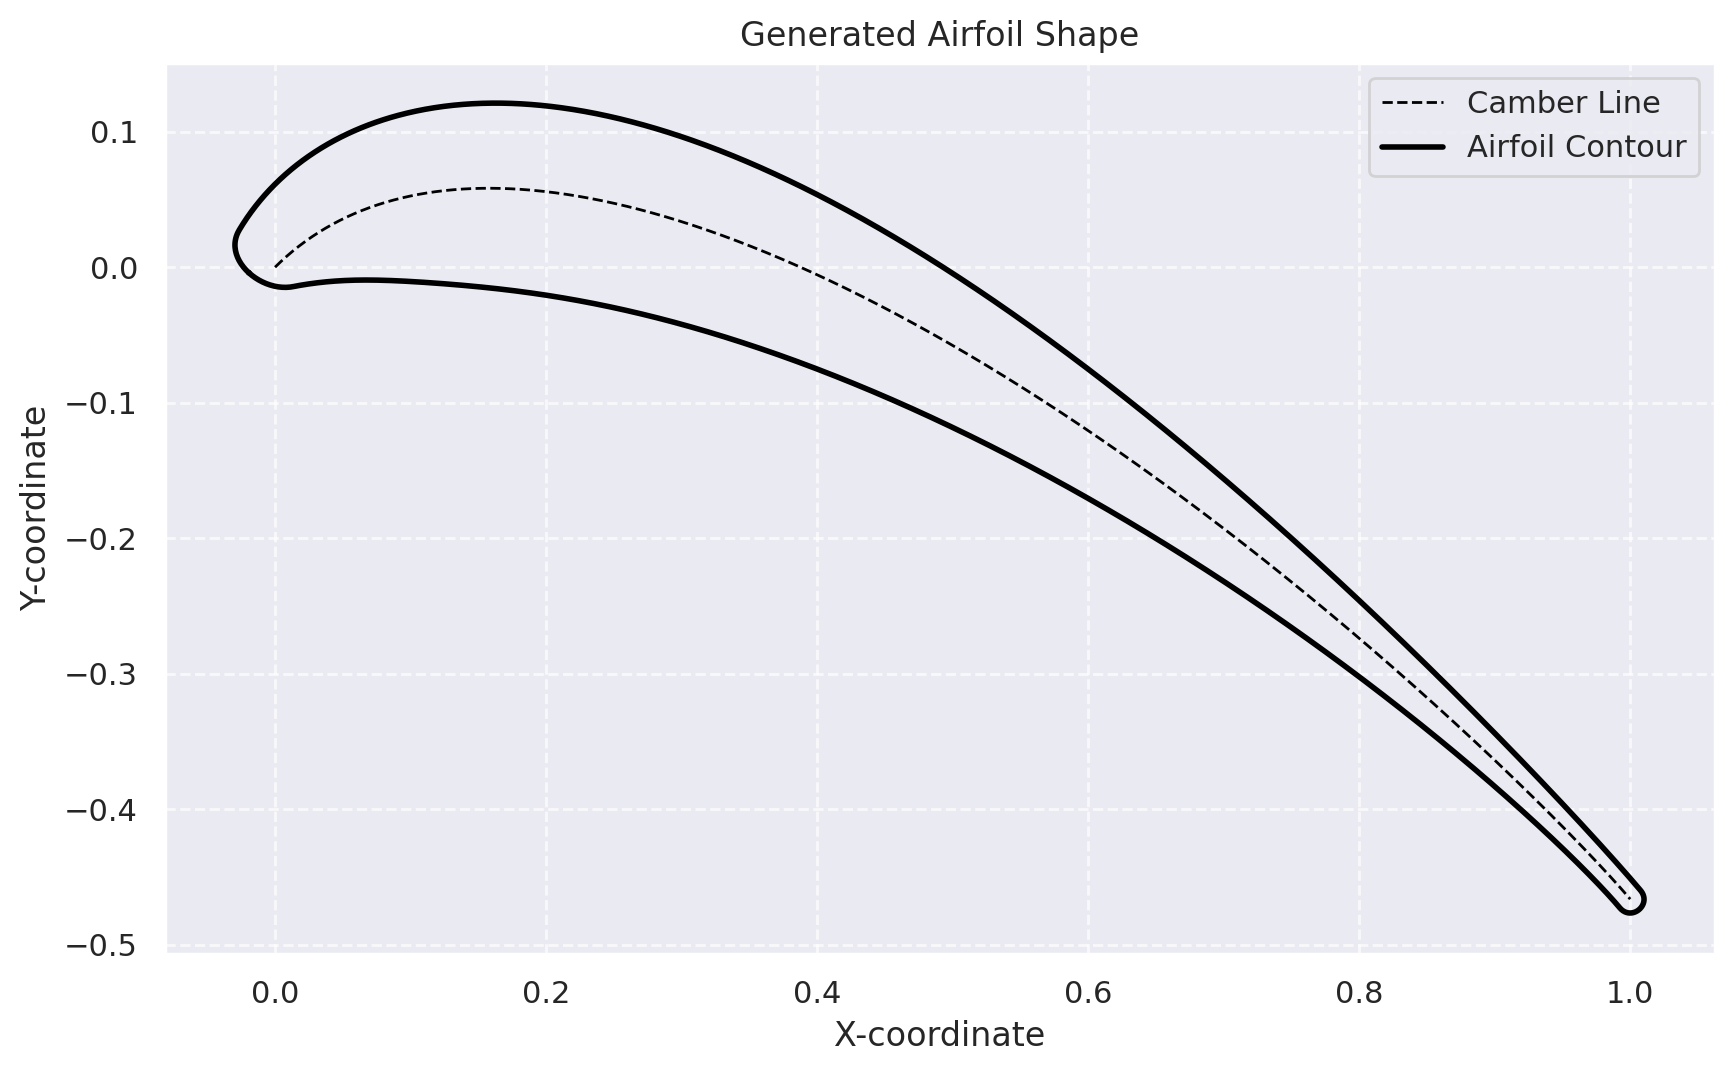


Episode 2/10
Best reward: tensor([[ 0.1018, -0.4323,  0.0749, -1.5023]]) - 2.159179925918579


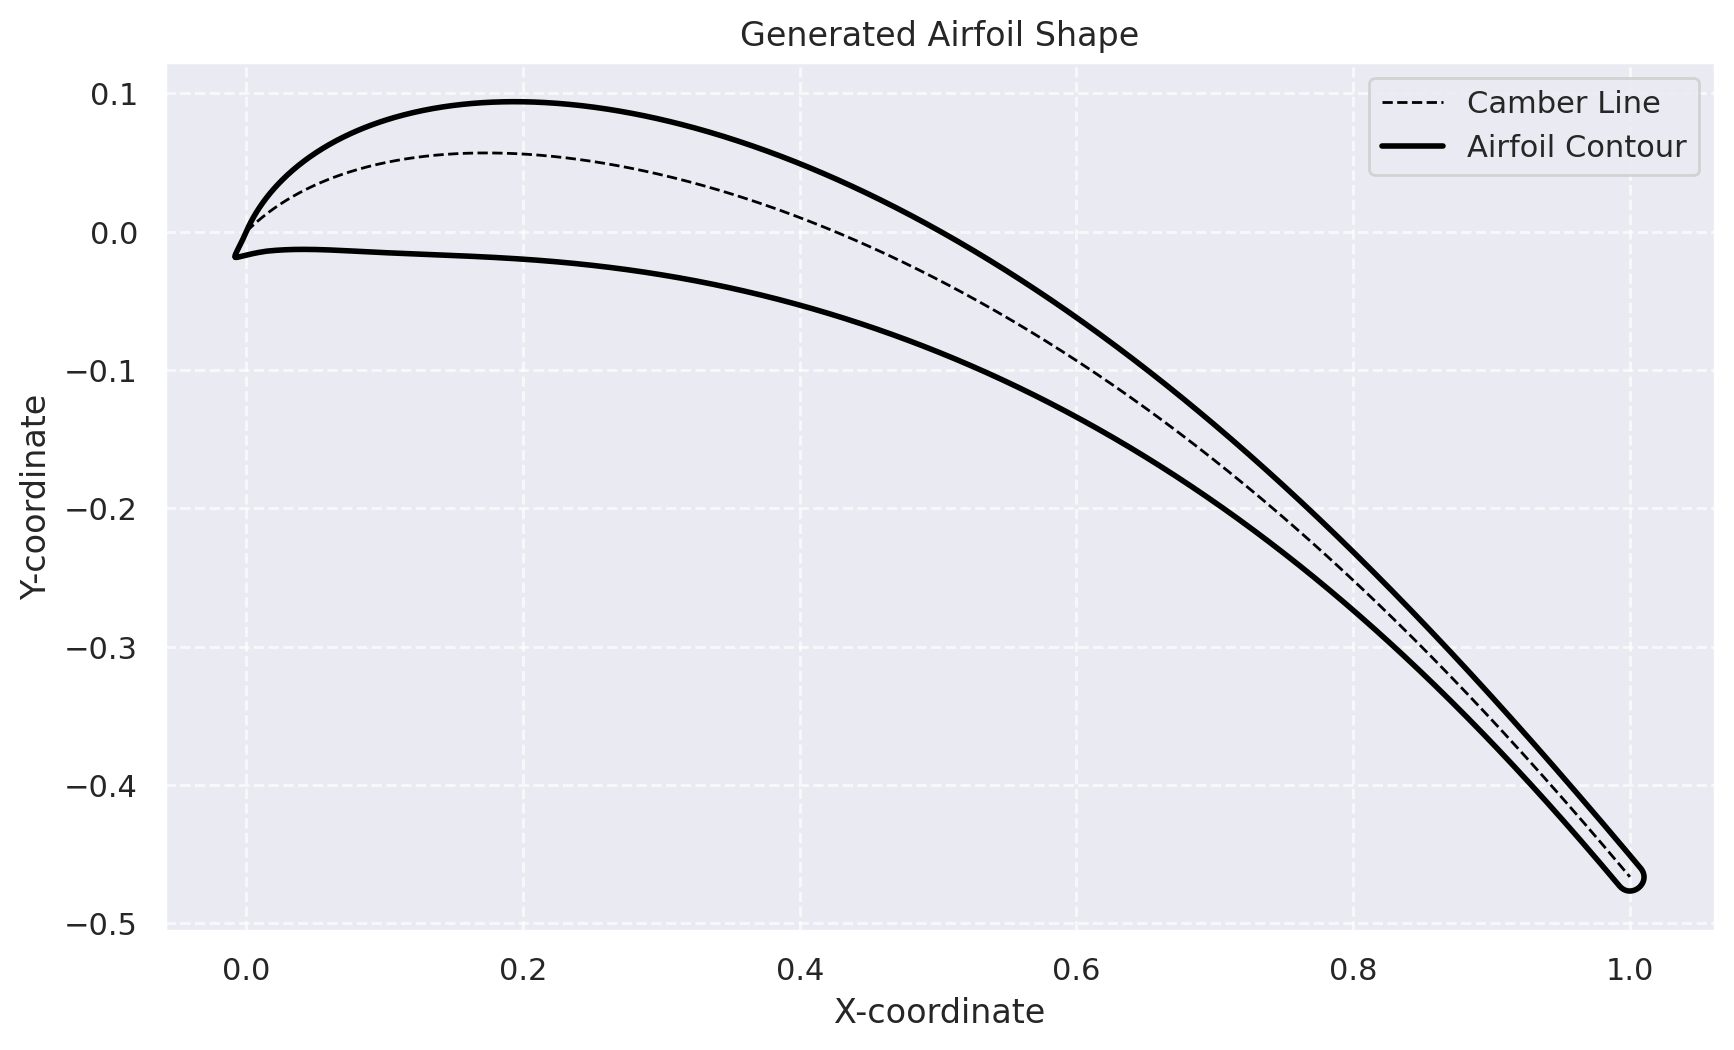


Episode 3/10
Best reward: tensor([[ 0.8699,  0.3993, -0.1351,  0.6362]]) - 2.5751075744628906


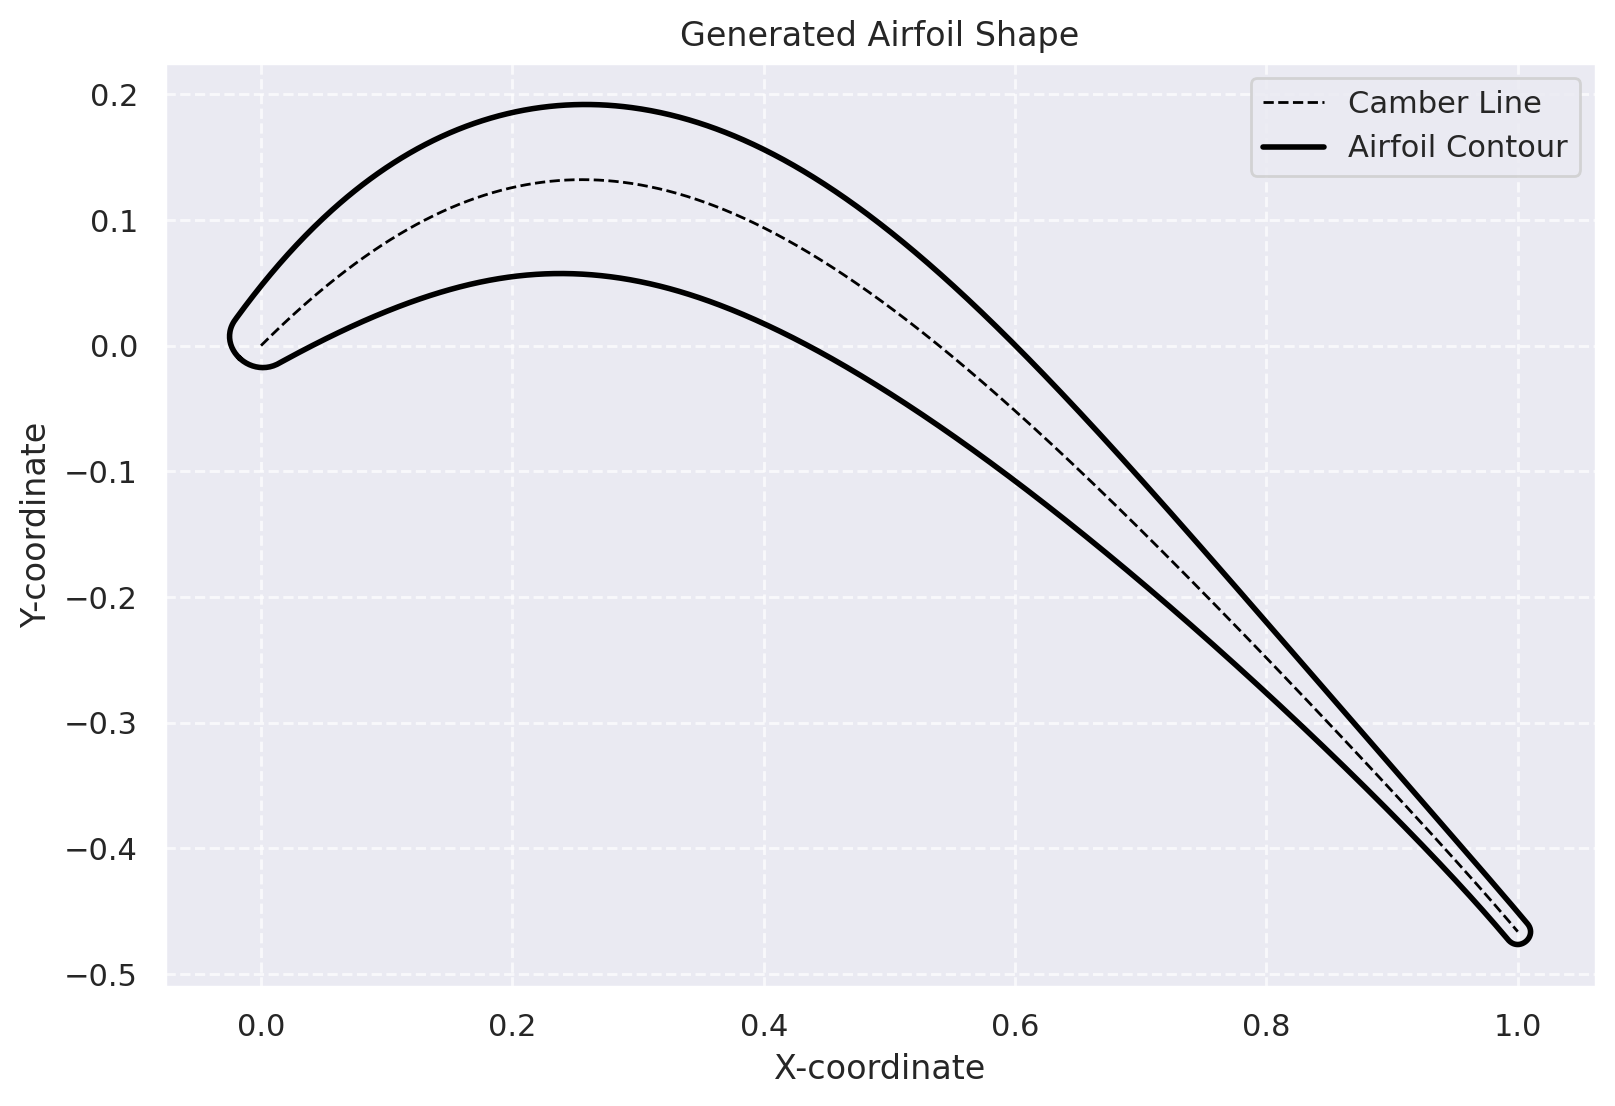


Episode 4/10
Best reward: tensor([[ 0.6338,  0.3843, -1.3616, -0.5471]]) - 7.064280986785889


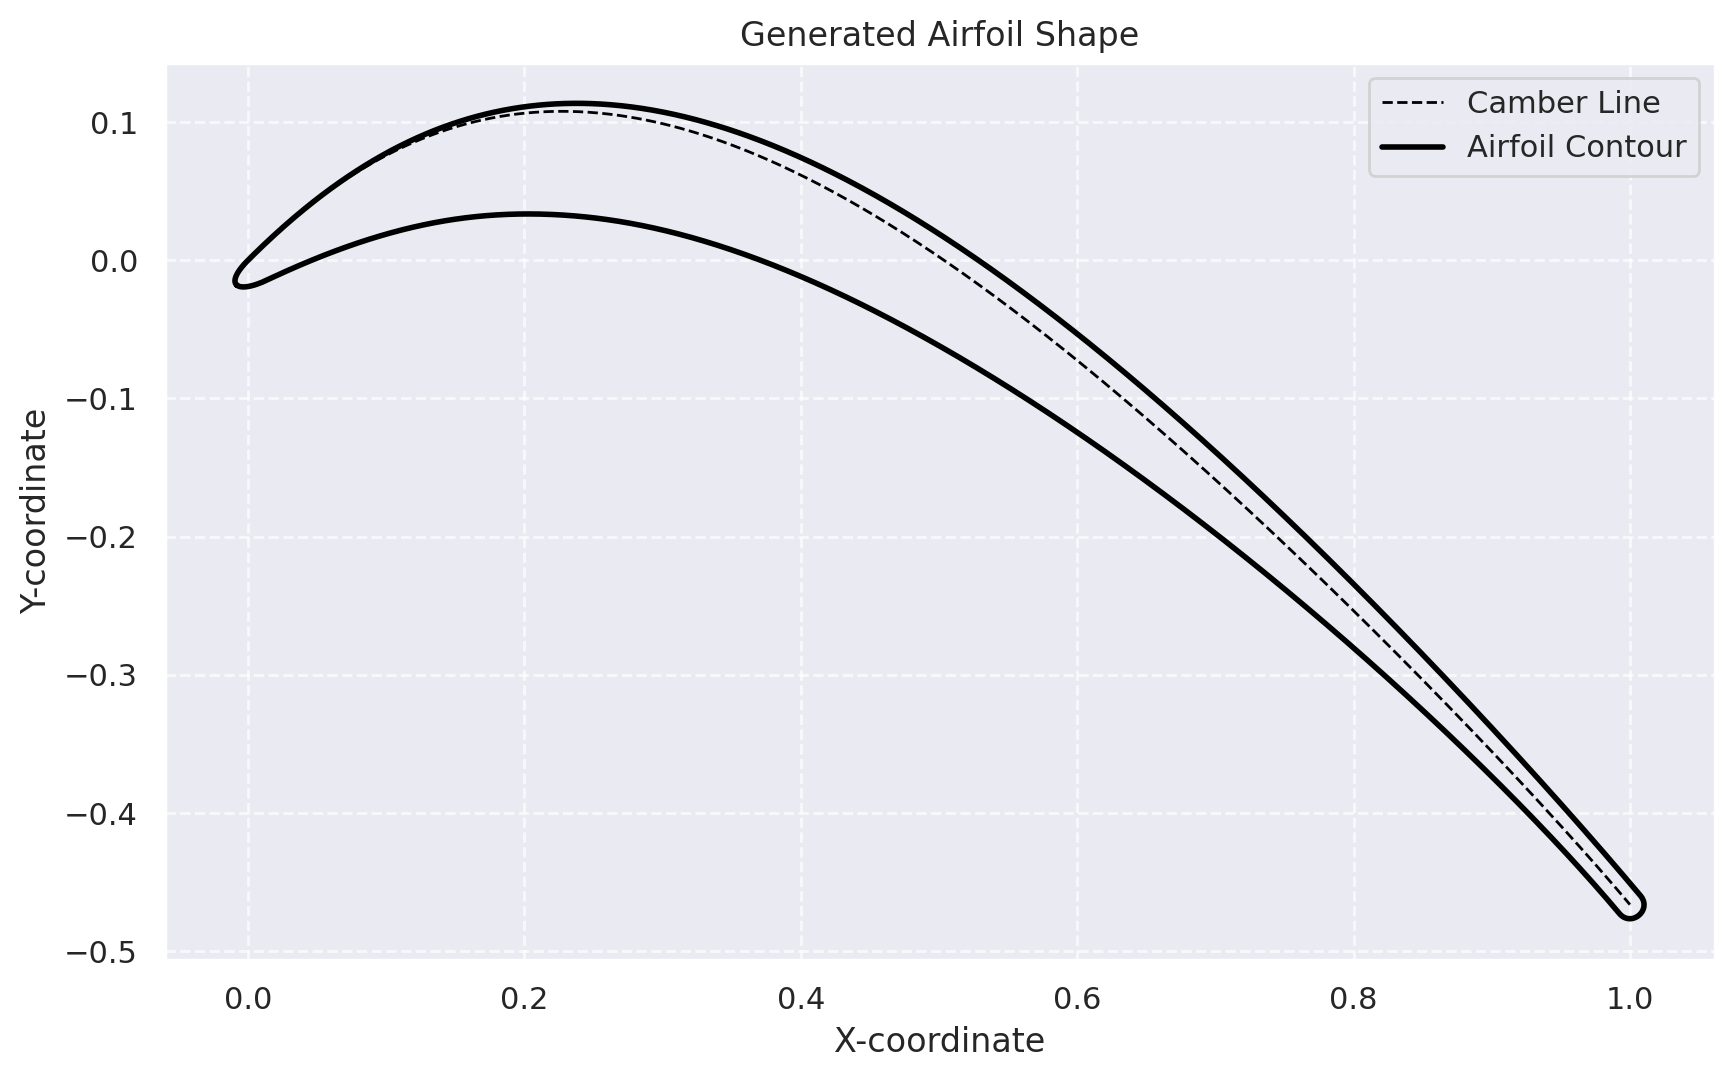


Episode 5/10


CasADi - 2025-09-03 14:30:27 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 2111 (row 34, col 17).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-09-03 14:30:27 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 2111 (row 34, col 17).") [.../casadi/core/oracle_function.cpp:408]


Best reward: tensor([[-0.0819,  0.9114, -0.7237, -0.7991]]) - 2.0786659717559814


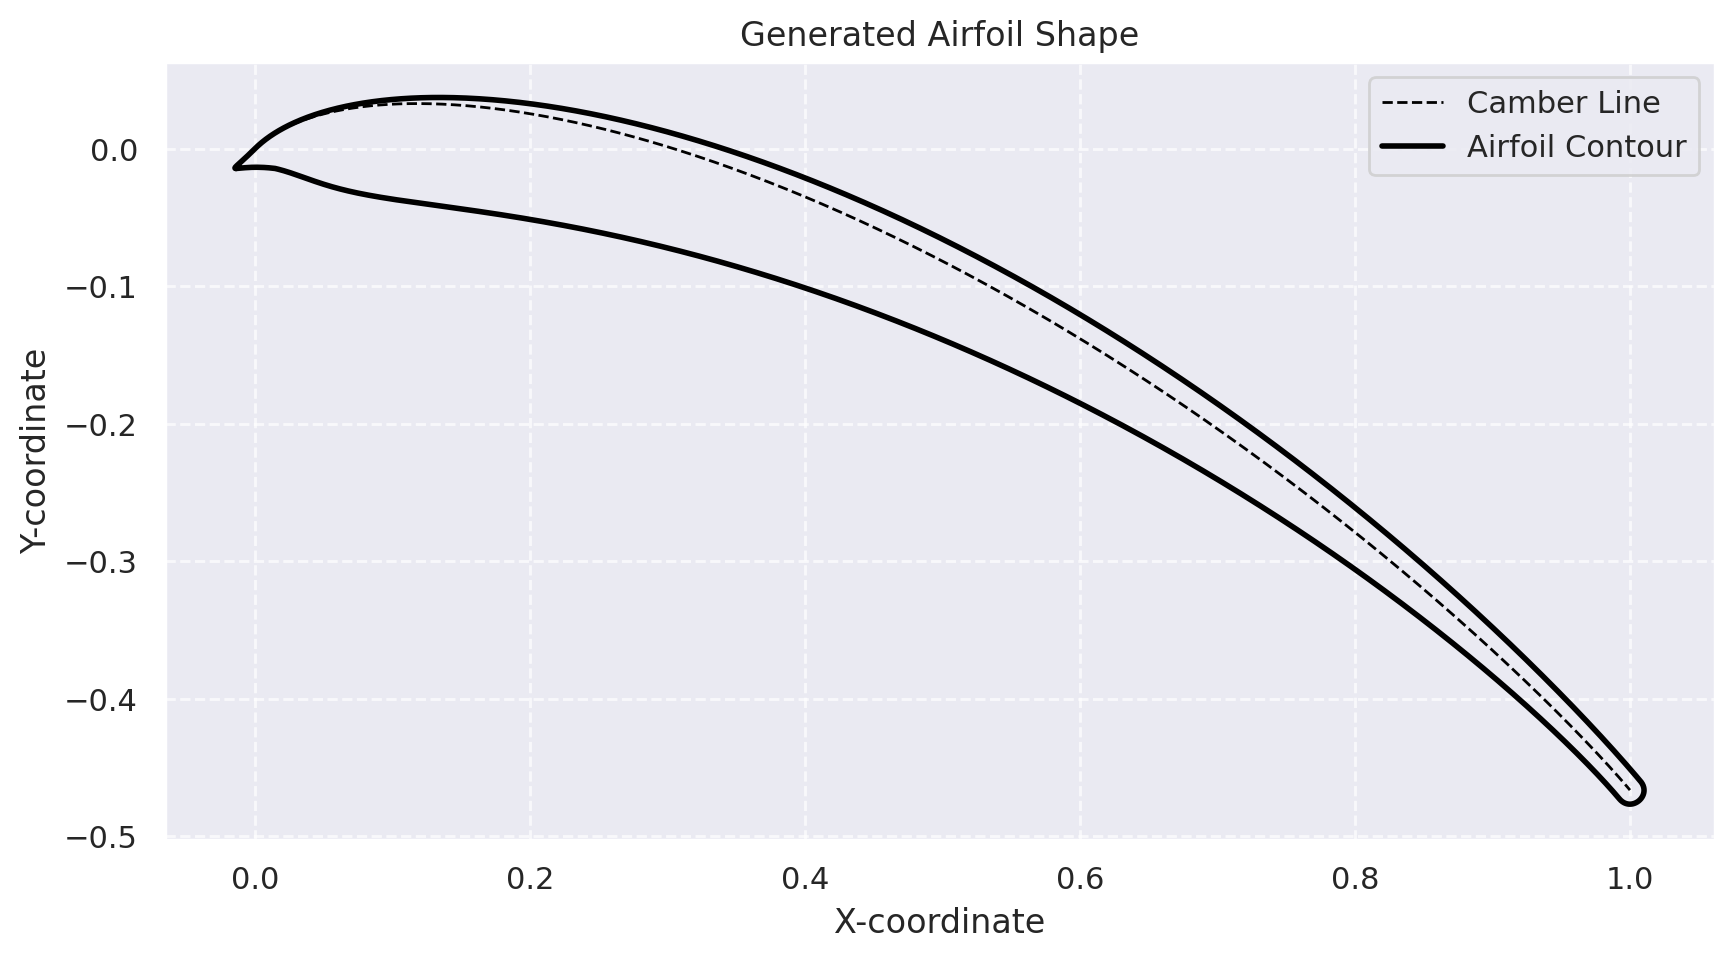


Episode 6/10


CasADi - 2025-09-03 14:31:16 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 2111 (row 34, col 17).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-09-03 14:31:16 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 2111 (row 34, col 17).") [.../casadi/core/oracle_function.cpp:408]


Best reward: tensor([[ 0.3911, -1.4530,  0.0538,  1.6854]]) - 2.163869857788086


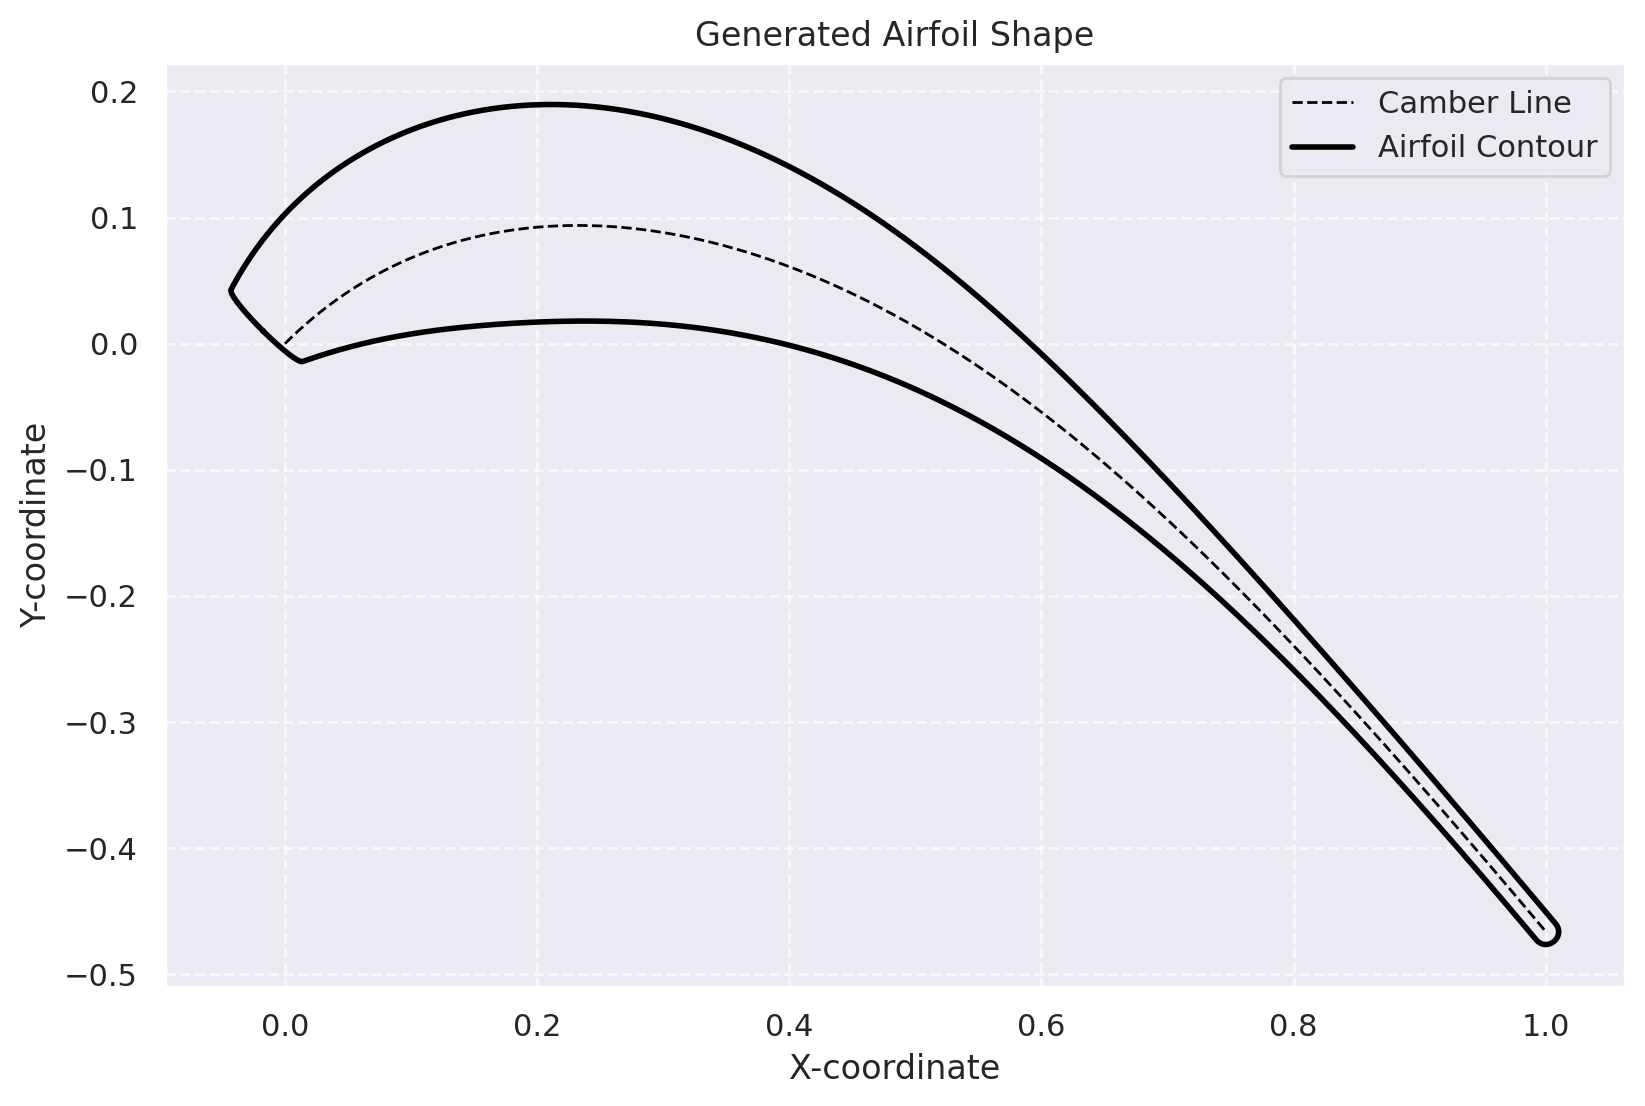


Episode 7/10


CasADi - 2025-09-03 14:31:47 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 2111 (row 34, col 17).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-09-03 14:31:47 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 2111 (row 34, col 17).") [.../casadi/core/oracle_function.cpp:408]


Best reward: tensor([[ 0.0417,  2.8331, -0.7714, -0.6380]]) - 2.860912561416626


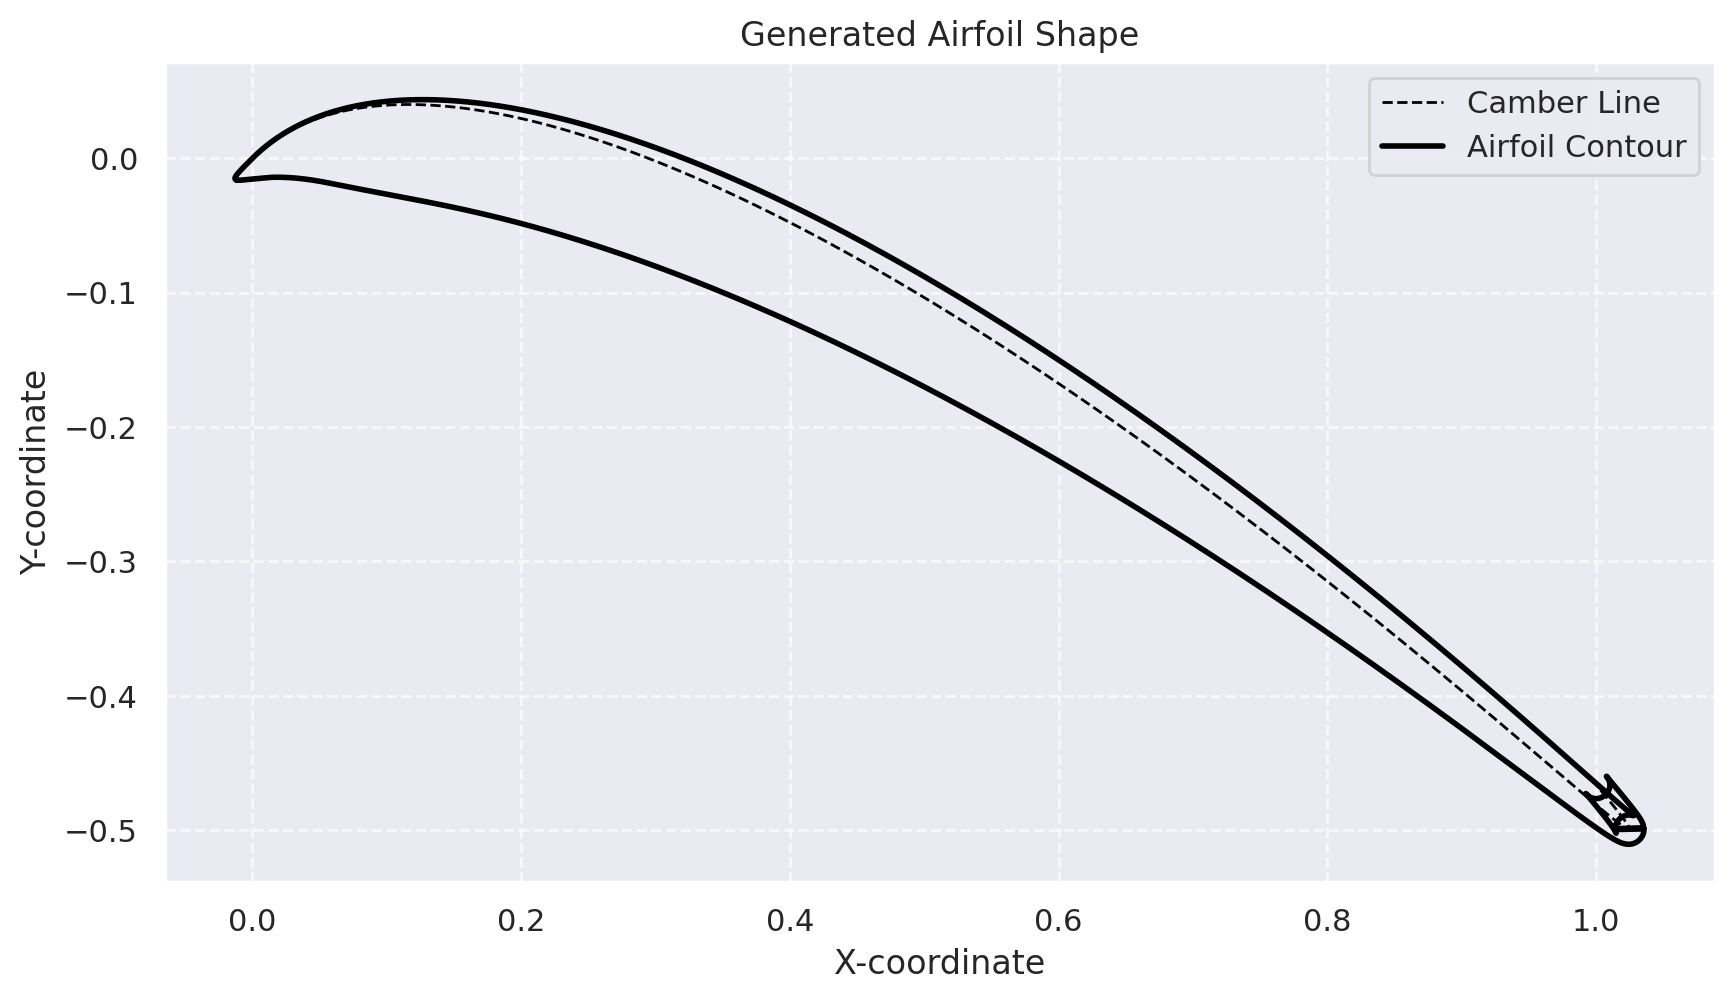


Episode 8/10


CasADi - 2025-09-03 14:32:50 WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-09-03 14:32:50 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 2 (row 34, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-09-03 14:32:51 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 2 (row 34, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-09-03 14:32:51 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 2 (row 34, col 0).") [.../casadi/core/oracle_function.cpp:408]


Best reward: tensor([[ 0.3677, -0.3138, -1.0926,  1.0146]]) - 2.060837507247925


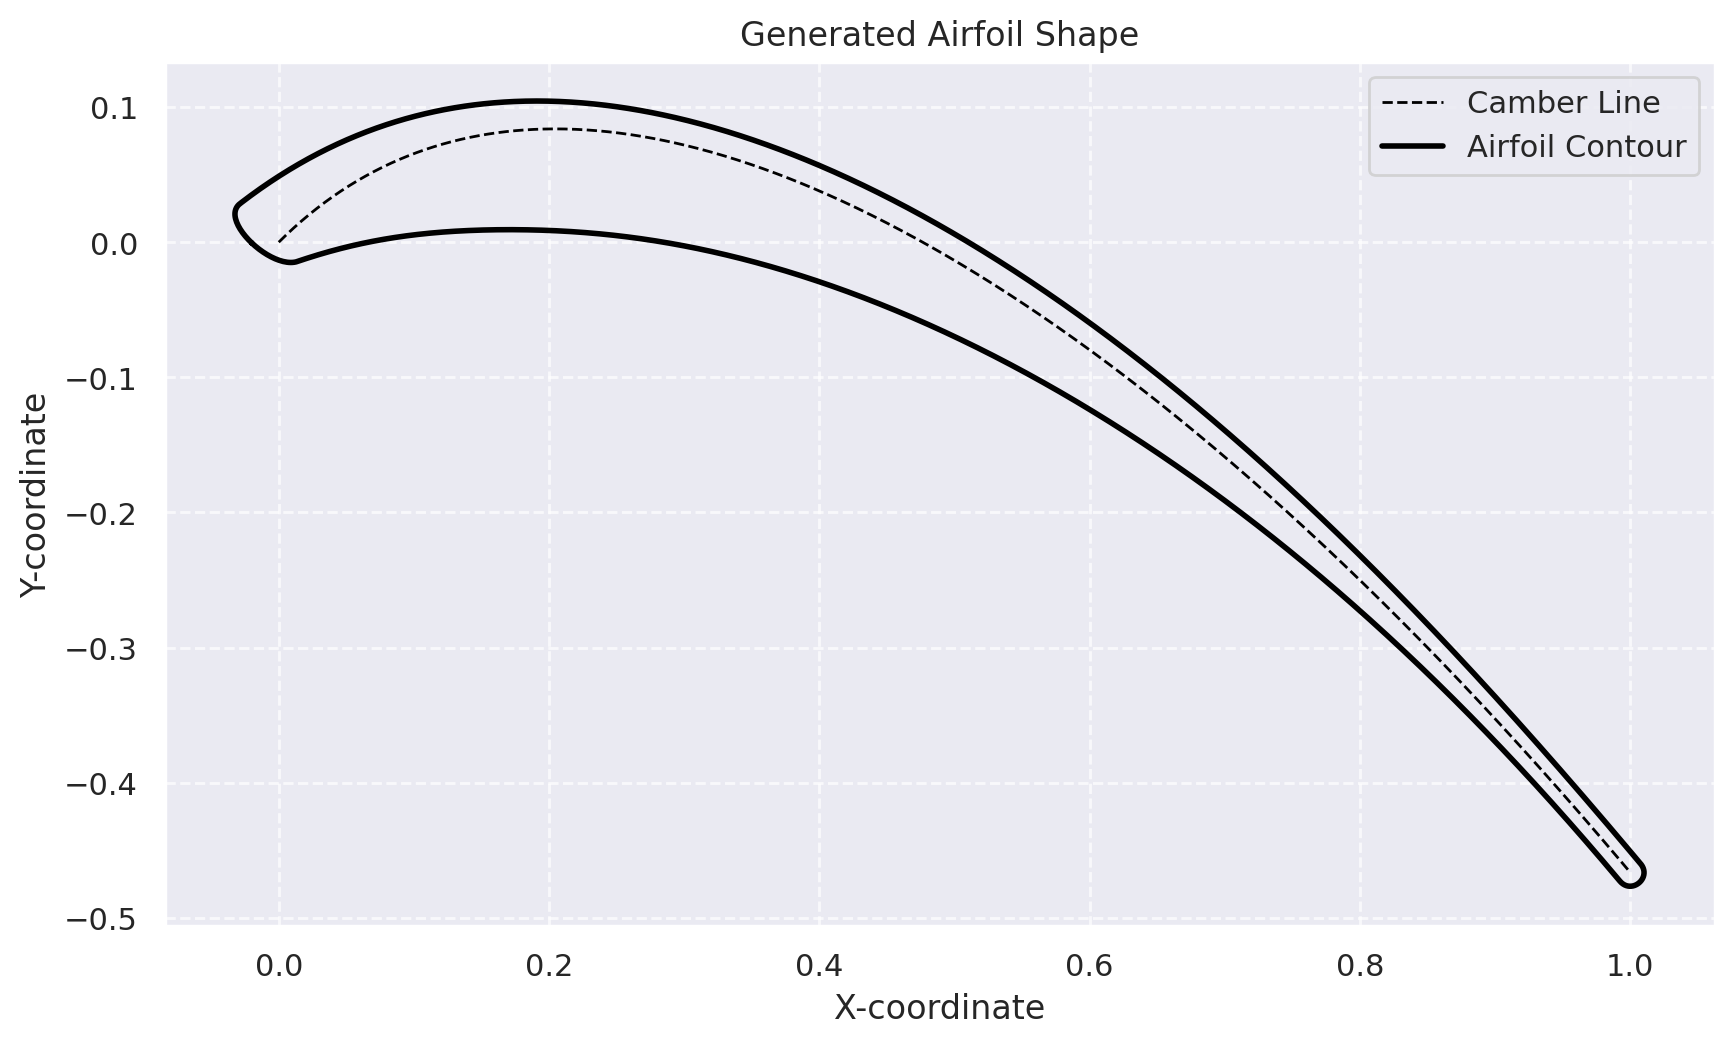


Episode 9/10
Best reward: tensor([[ 0.3575,  3.4425, -1.2590,  2.8347]]) - 2.6609604358673096


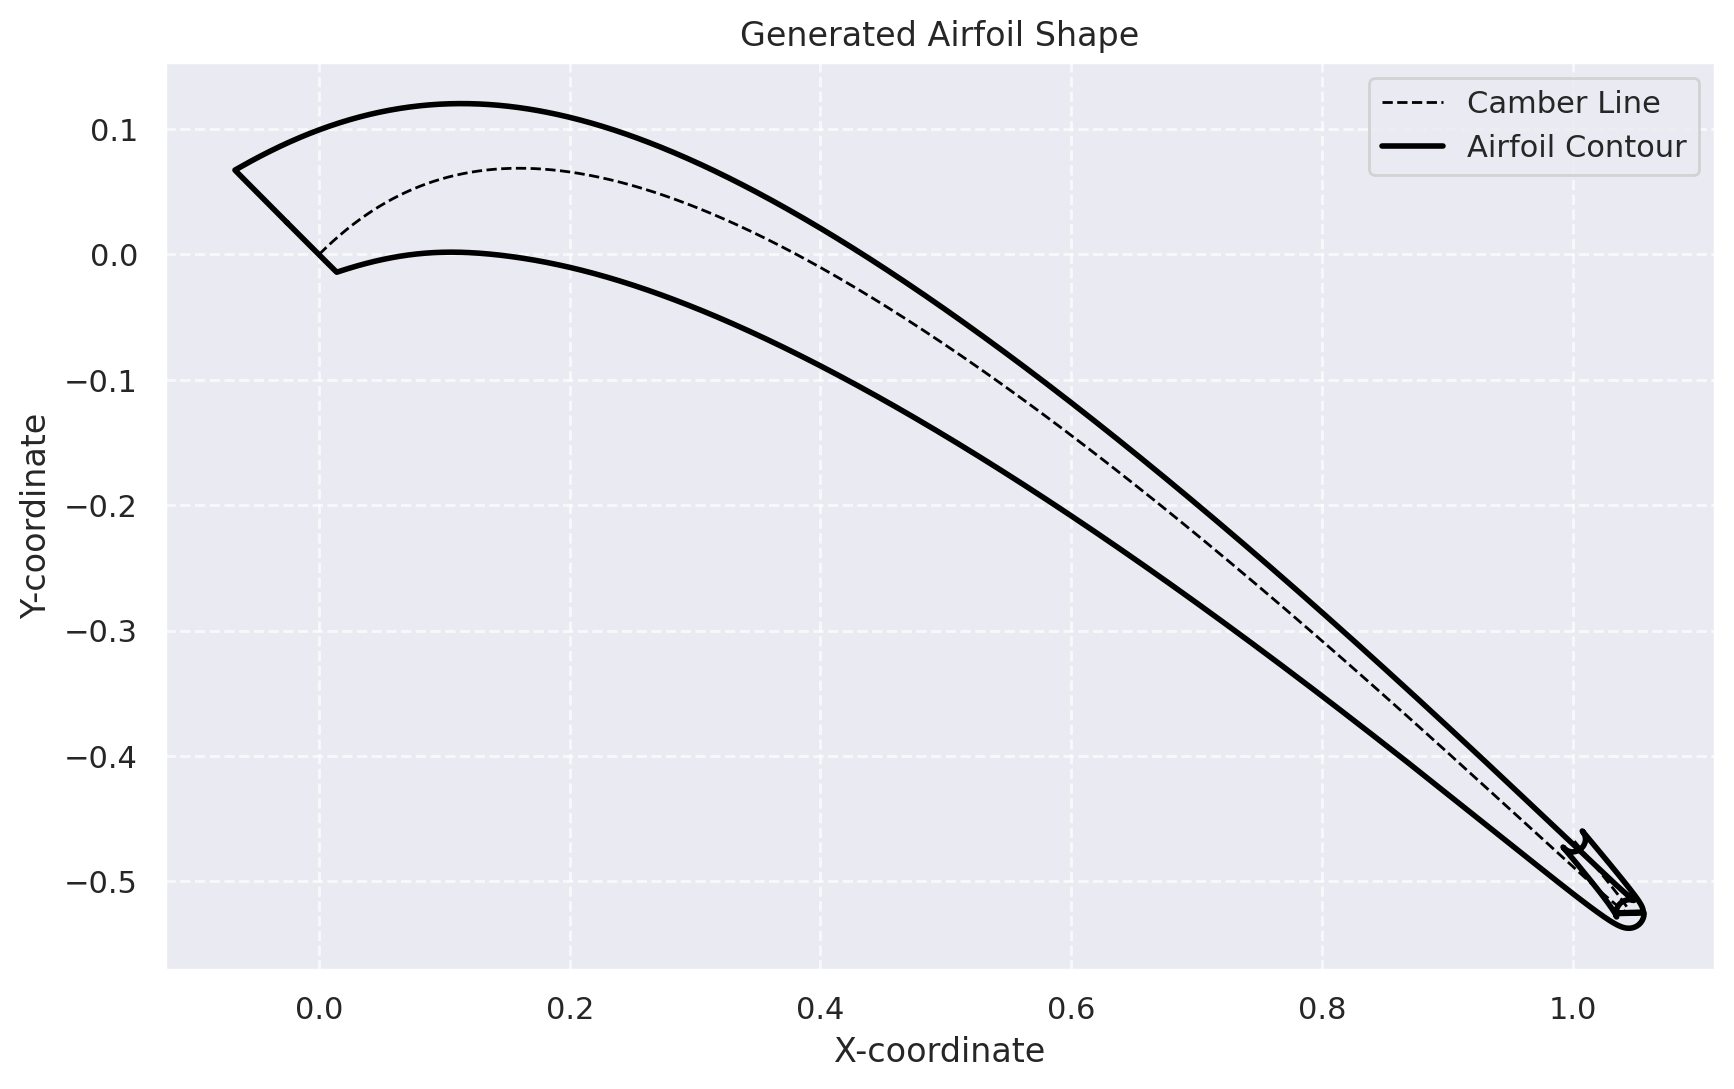


Episode 10/10


CasADi - 2025-09-03 14:34:19 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 2111 (row 34, col 17).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-09-03 14:34:19 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 2111 (row 34, col 17).") [.../casadi/core/oracle_function.cpp:408]


Best reward: tensor([[ 0.1672, -0.7066, -0.3476, -1.9322]]) - 2.6153934001922607


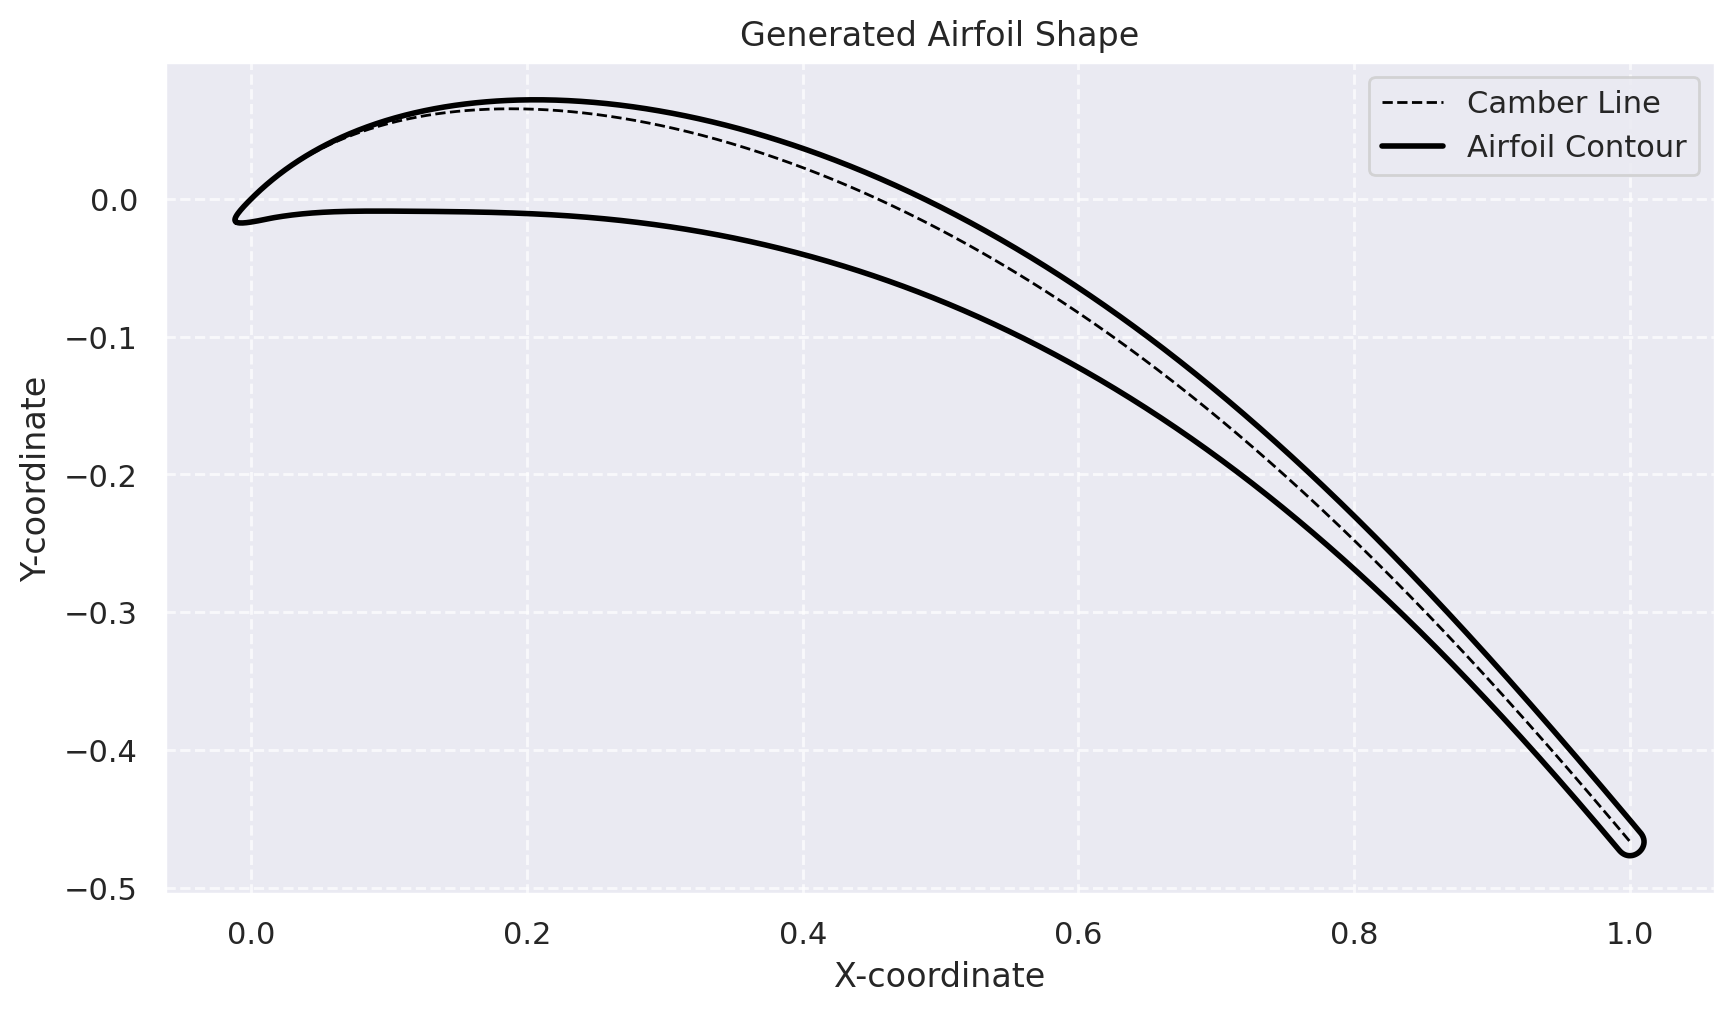

  Recent 10 episodes average: 0.2883

Training completed!
Final rewards: [0.6934236288070679, -0.11182413250207901, 0.590313732624054, 0.7934447526931763, 0.9051704406738281]


In [68]:
n_numbers=4 
state_dim=2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
    
# Initialize networks
actor = Actor(state_dim, n_numbers).to(device)
critic = Critic(state_dim).to(device)


actor, critic, rewards = train_ppo(actor, critic,
            external_eval_func=external_eval,  # Replace with your external_eval
            n_numbers=4,
            num_episodes=10,  
            steps_per_episode=64  
        )
    
print(f"\nTraining completed!")
print(f"Final rewards: {rewards[-5:]}") 

Text(0.5, 0, 'Iteration')

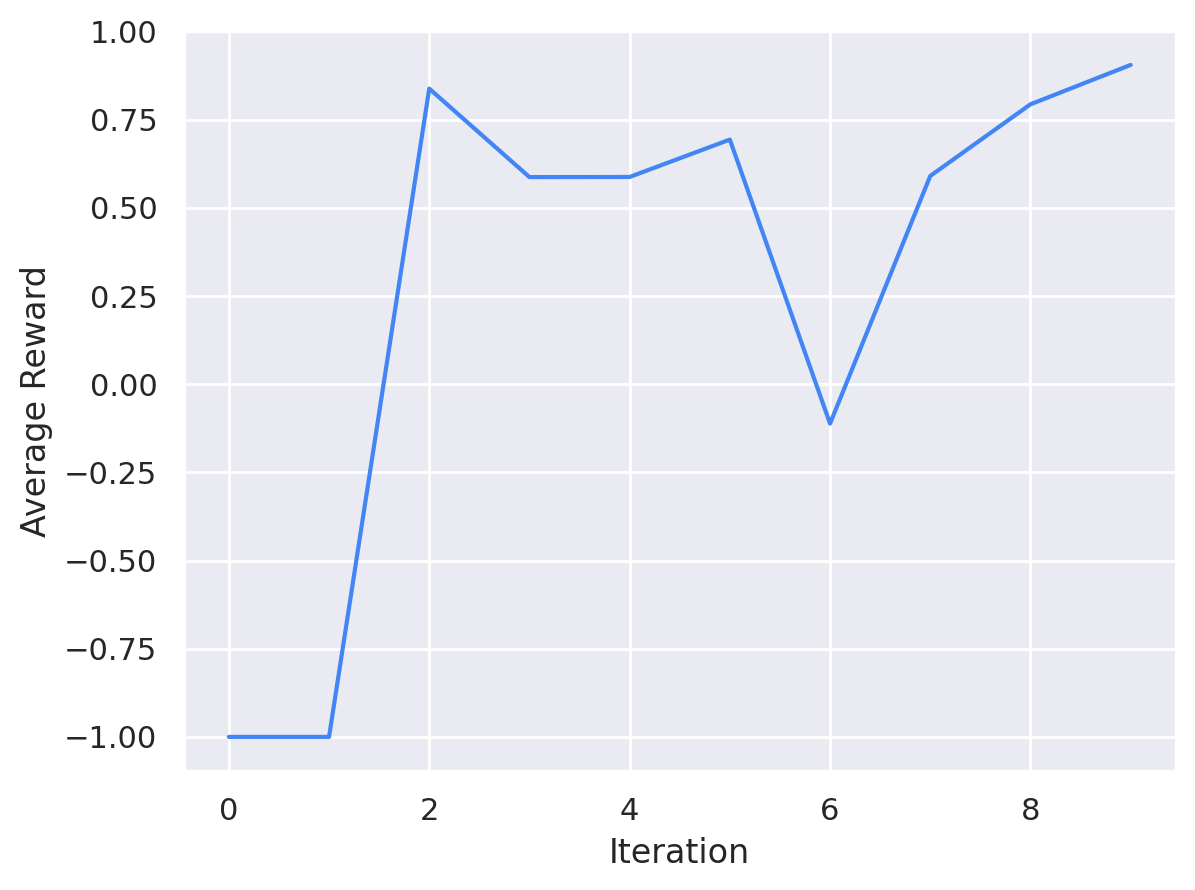

In [70]:
plt.plot(rewards)
plt.ylabel("Average Reward")
plt.xlabel("Iteration")